In [1]:
import scanpy as sc

In [2]:
adata = sc.read_h5ad("clono_filtered_counts_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 25066 × 15093
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [3]:
adata.obs

,cell_id,nCount_RNA,nFeature_RNA,patient_id,percent_mito,Response_3m,sample_source
0,Good_Li_2023ac01_AAACGGGAGATGTGTA-1,652,433,ac01,3.935860,OR,Deng
1,Good_Li_2023ac01_AAAGATGCAGCCTTGG-1,18106,3790,ac01,2.465065,OR,Deng
2,Good_Li_2023ac01_AAAGTAGTCATGGTCA-1,1145,688,ac01,3.858785,OR,Deng
3,Good_Li_2023ac01_AAATGCCAGTACCGGA-1,3430,1413,ac01,2.677339,OR,Deng
4,Good_Li_2023ac01_AAATGCCGTTCAGACT-1,924,554,ac01,1.731161,OR,Deng
...,...,...,...,...,...,...,...
25061,Sheih_TTTGGTTCATTGTGCA-5,2722,1253,NHL-7,6.673766,CR,Sheih
25062,Sheih_TTTGGTTTCGATCCCT-5,6209,1980,NHL-7,3.170656,CR,Sheih
25063,Sheih_TTTGGTTTCTACGAGT-5,5606,1925,NHL-7,2.868498,CR,Sheih
25064,Sheih_TTTGTCACAGTCAGAG-5,2317,1049,NHL-7,2.549102,CR,Sheih


In [4]:
del adata.uns
adata

AnnData object with n_obs × n_vars = 25066 × 15093
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'

In [5]:
adata.obs['cell_id'] = adata.obs.index

In [ ]:
# adata.write_h5ad("clono_filtered_counts_adata_for_R.h5ad")

In [6]:
var_genes_all = adata.var.highly_variable

print("Highly variable genes: %d"%sum(var_genes_all))

Highly variable genes: 4989


In [7]:
adata2 = adata.copy()
# Normalize the data for running highly_variable_genes
sc.pp.normalize_total(adata2)
# Logarithmize the data
sc.pp.log1p(adata2)


In [8]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0010, max_mean=4, min_disp=0.3, batch_key="sample_source")
print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

Highly variable genes intersection: 1184
Number of batches where gene is variable:
highly_variable_nbatches
0    5334
1    3640
2    2874
3    2061
4    1184
Name: count, dtype: int64


In [9]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches == 4))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))


Any batch var genes: 9759
All data var genes: 4989
Overlap: 3110
Variable genes in all batches: 1184
Overlap batch instersection and all: 420


In [10]:
var_select = adata2.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
len(var_genes)

6119

In [11]:
var_select[1:10]


2      True
3     False
4     False
5     False
6      True
7      True
8     False
9     False
10     True
Name: highly_variable_nbatches, dtype: bool

In [ ]:
var_genes_combat[1:10]

2      True
3     False
4     False
5     False
6      True
7     False
8     False
9     False
10    False
Name: highly_variable, dtype: bool

In [ ]:
adata2.X.min(), adata2.X.max()  

(0.0, 7.202501)

In [ ]:
adata.X.min(), adata.X.max()

(0.0, 3051.0)

In [12]:
adata_combat = sc.AnnData(X=adata.X, var=adata.var, obs=adata.obs)

sc.pp.normalize_total(adata_combat)
sc.pp.log1p(adata_combat)



In [13]:
# store the raw data
adata_combat.raw = adata_combat

# run combat
sc.pp.combat(adata_combat, key="sample_source")

Found 163 genes with zero variance.


/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:351: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:351: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [14]:
adata_combat.X.min(), adata_combat.X.max()

(-4.455057393948623, 14.199179792087453)

In [15]:
adata_combat.X.shape

(25066, 15093)

Highly variable genes: 2066


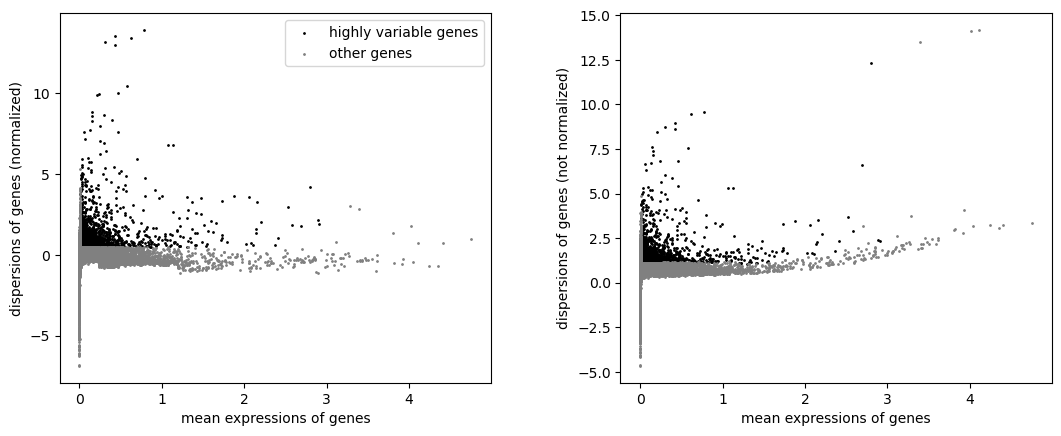

In [16]:
sc.pp.highly_variable_genes(adata_combat)
print("Highly variable genes: %d" %sum(adata_combat.var.highly_variable))
sc.pl.highly_variable_genes(adata_combat)


In [17]:
# save the combat corrected data
adata_combat.write("combat_integrated_v2.h5ad")
cell_metadata = adata_combat.obs
gene_metadata = adata_combat.var
cell_metadata.to_csv("combat_integrated_cell_metadata.csv", index=False)
gene_metadata.to_csv("combat_integrated_gene_metadata.csv", index=False)

In [24]:
sc.pp.pca(adata_combat, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_combat, n_pcs=50, n_neighbors=30)

sc.tl.umap(adata_combat)
sc.tl.tsne(adata_combat, n_pcs=50)

In [32]:
# compare var genes
var_genes_combat = adata_combat.var.highly_variable
print("With all data %d"%sum(var_genes_all))
print("With combat %d"%sum(var_genes_combat))
print("Overlap %d"%sum(var_genes_all & var_genes_combat))

print("With at least 1 batch %d"%sum(var_select))
print("Overlap %d"%sum(var_genes_combat & var_select))

With all data 4989
With combat 2066
Overlap 1062
With at least 1 batch 6119
Overlap 1808


In [34]:
# compute tsna and umap for log normalized data 
sc.pp.pca(adata2, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata2, n_pcs=50, n_neighbors=30)

sc.tl.umap(adata2)
sc.tl.tsne(adata2, n_pcs=50)

/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


<Axes: title={'center': 'Combat corrected and integrated counts UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

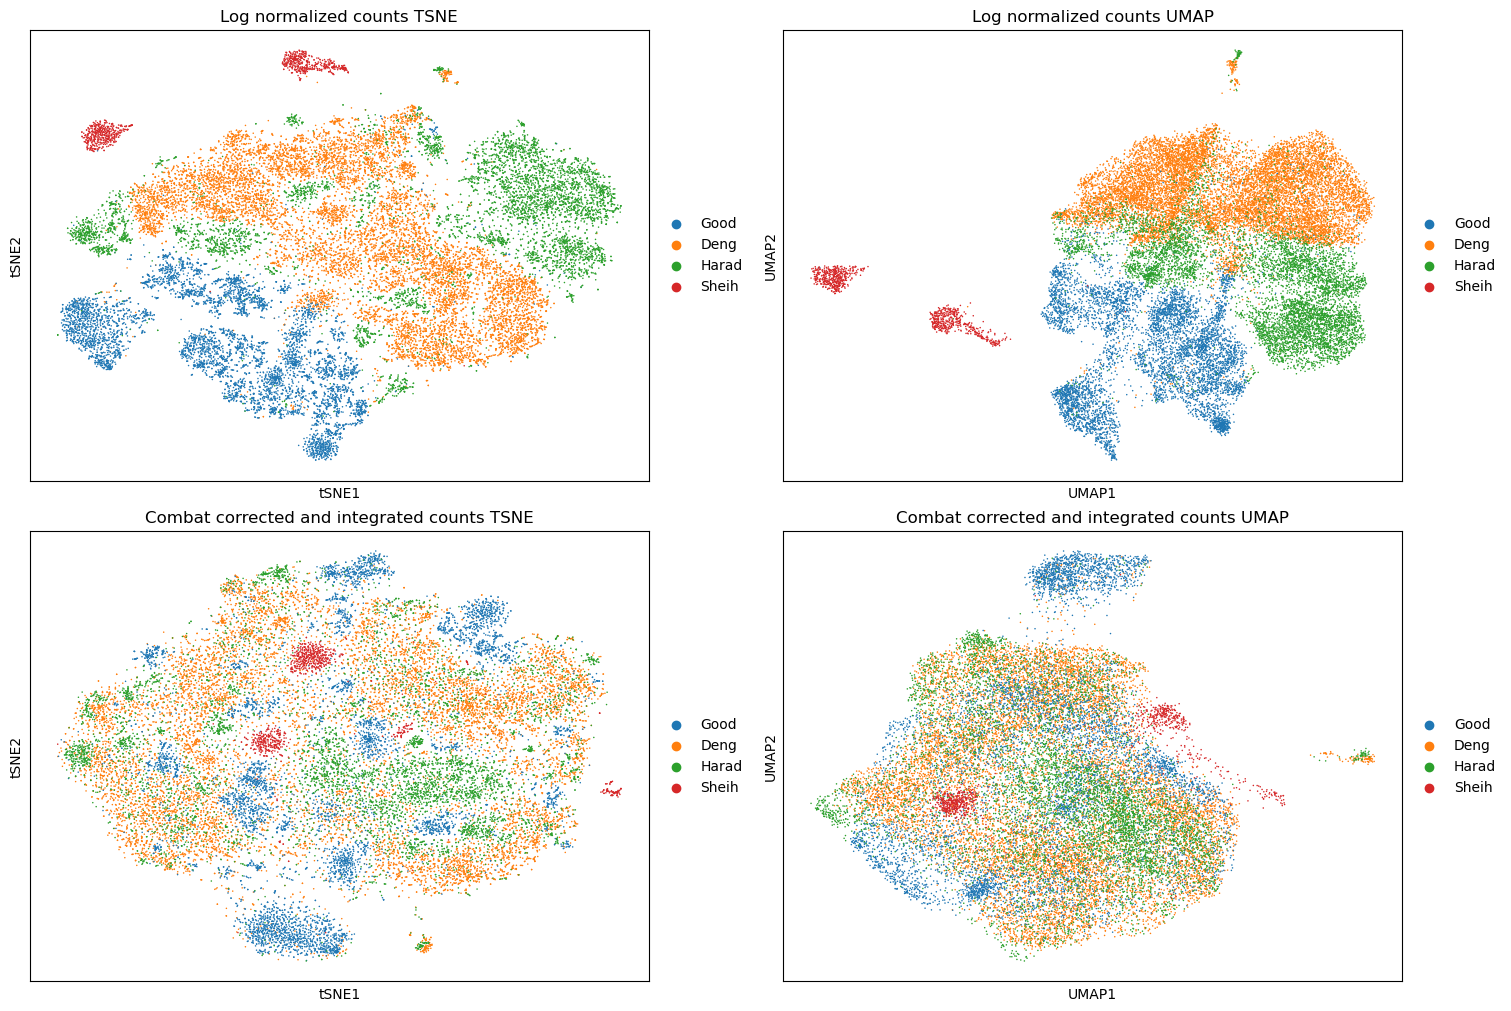

In [47]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(15,10), constrained_layout=True)
sc.pl.tsne(adata2, color="sample_source", title="Log normalized counts TSNE", ax=axs[0, 0], show=False)
sc.pl.tsne(adata_combat, color="sample_source", title="Combat corrected and integrated counts TSNE", ax=axs[1, 0], show=False)
sc.pl.umap(adata2, color="sample_source", title="Log normalized counts UMAP", ax=axs[0, 1], show=False)
sc.pl.umap(adata_combat, color="sample_source", title="Combat corrected and integrated counts UMAP", ax=axs[1, 1], show=False)

In [ ]:
# write a csv file with the metadata
cell_metadata_combat = adata_combat.obs


In [53]:
# save the combat corrected data
adata_combat.write("combat_integrated.h5ad")

In [ ]:
# save the combat corrected data
adata_combat.write("combat_integrated.h5ad")
cell_metadata = adata_combat.obs
gene_metadata = adata_combat.var
cell_metadata.to_csv("combat_integrated_cell_metadata.csv", index=False)
gene_metadata.to_csv("combat_integrated_gene_metadata.csv", index=False)

### How data the batch effect looks like at baseline

In [44]:
# compute tsna and umap for log normalized data 
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_pcs=50, n_neighbors=30)

sc.tl.umap(adata)
sc.tl.tsne(adata, n_pcs=50)

/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


<Axes: title={'center': 'Raw counts UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

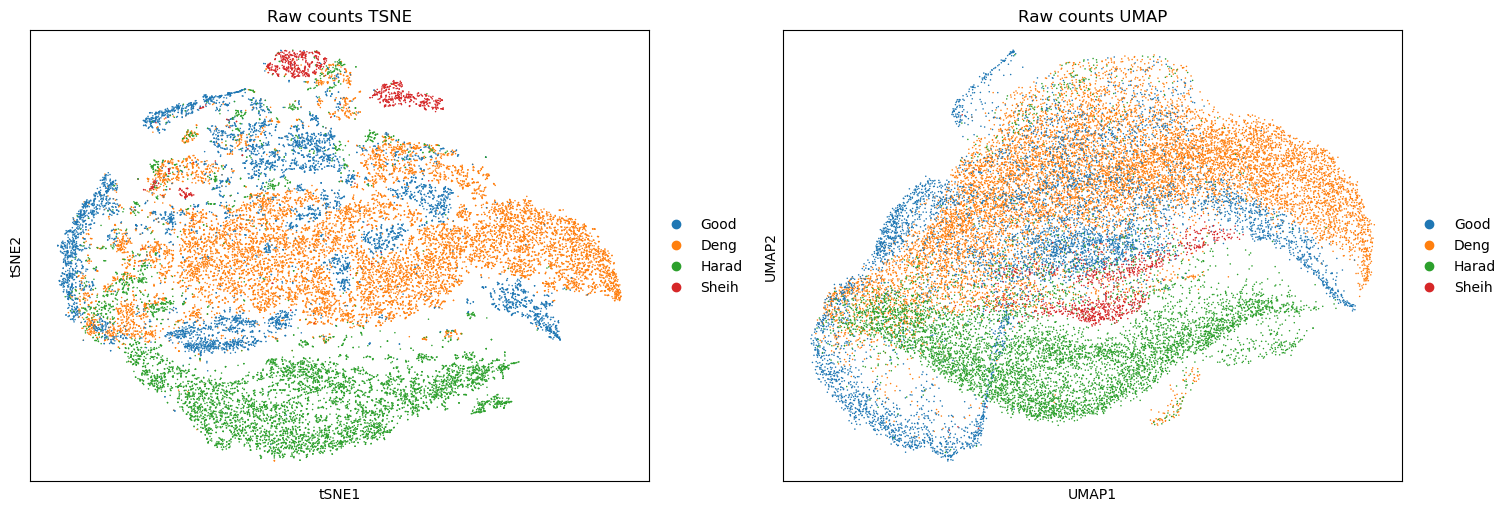

In [52]:
# plot the UMAp and TSNE of uncorrected raw counts data

fig, axs = plt.subplots(1,2, figsize=(15,5), constrained_layout=True)
sc.pl.tsne(adata, color="sample_source", title="Raw counts TSNE", ax=axs[0], show=False)

sc.pl.umap(adata, color="sample_source", title="Raw counts UMAP", ax=axs[1], show=False)
